## Split data into train and test set ##

In [34]:
# _x_data, _y_data = collect_images(data)                
# target = np.zeros((len(_y_data), 10))
# target[np.arange(len(_y_data)),_y_data] = 1
# _y_data = target
# x_train, x_test, y_train, y_test = train_test_split(_x_data,_y_data,random_state=42)

# pickle.dump(x_test, open('x_test.p','wb'))
# pickle.dump(x_train, open('x_train.p','wb'))
# pickle.dump(y_train, open('y_train.p','wb'))
# pickle.dump(y_test, open('y_test.p','wb'))

## Setup the Model ##

<IPython.core.display.Javascript object>


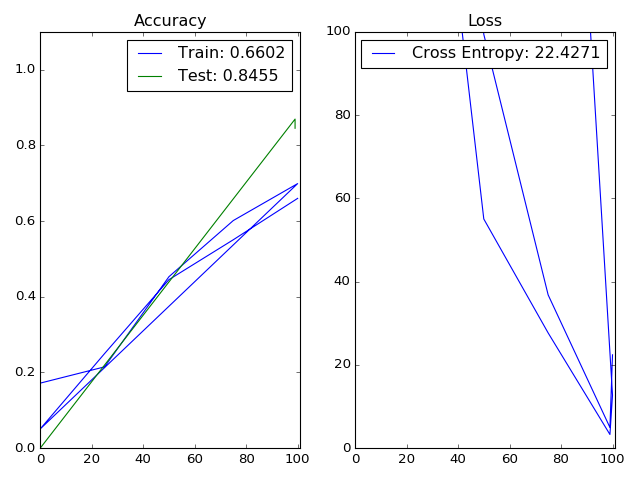

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
step 0, training accuracy 0.0507812
step 25, training accuracy 0.25
step 50, training accuracy 0.445312
step 75, training accuracy 0.550781
step 99, test accuracy 0.845453
step 100, training accuracy 0.660156


In [10]:
from __future__ import print_function

%matplotlib notebook 

import tensorflow as tf
import numpy as np

from os.path import join
from helper_functions import *
from visualization import Visualization
from sklearn.model_selection import train_test_split

EPOCHS = 101
LEARNING_RATE = 1e-4
BATCH_SIZE = 256

def weight_variable(shape):
    with tf.name_scope('weights'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        weight = tf.Variable(initial)
        variable_summaries(weight)
        return weight

def bias_variable(shape):
    with tf.name_scope('biases'):
        initial = tf.constant(0.1, shape=shape)
        bias = tf.Variable(initial)
        variable_summaries(bias)
        return bias
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


class DigitClassifier():
    def __init__(self, data, filter_type='original'):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        viz = Visualization(epochs=EPOCHS)
        
        # Load train and test sets
        x_train = pickle.load(open('x_train.p'))
        x_test = pickle.load(open('x_test.p'))
        self.y_train = pickle.load(open('y_train.p'))
        self.y_test = pickle.load(open('y_test.p'))                
        self._num_examples = len(x_train)
        
        # Flatten training images
        n_samples = len(x_train)
        self.x_train = x_train.reshape((n_samples,-1))
        n_samples = len(x_test)
        self.x_test = x_test.reshape((n_samples,-1))        
        
        # Get flattened test images
        self.test_images = self.get_test_images(self.x_test)    
        
        # Explicitly initialize graph
        tf.reset_default_graph()
        
        global_step = tf.Variable(0, name='global_step', trainable=False)

        # Initialize input and target tensors
        with tf.name_scope('input'):
            x = tf.placeholder(tf.float32, shape=[None, 784], name='x-input')
            y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')
            tf.add_to_collection('x-input', x)
            tf.add_to_collection('y-input', y_)

        # Initialize weight and bias tensors
        with tf.name_scope('convolutional_layer_1'):
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])

        with tf.name_scope('input_reshape'):
            x_image = tf.reshape(x, [-1,28,28,1])
            tf.summary.image('input', x_image, 10)

        with tf.name_scope('convolutional_layer1'):
            h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

        with tf.name_scope('pooling_layer_1'):
            h_pool1 = max_pool_2x2(h_conv1)

        with tf.name_scope('convolutional_layer_2'):
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])        
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

        with tf.name_scope('pooling_layer_2'):
            h_pool2 = max_pool_2x2(h_conv2)

        with tf.name_scope('fully_connected_layer_1'):
            W_fc1 = weight_variable([7 * 7 * 64, 512])
            b_fc1 = bias_variable([512])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        with tf.name_scope('dropout'):
            keep_prob = tf.placeholder(tf.float32, name='keep_prob')
            tf.add_to_collection('keep_prob', keep_prob)
            tf.summary.scalar('dropout_keep_probability', keep_prob)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)                    

        with tf.name_scope('fully_connected_layer_2'):
            W_fc2 = weight_variable([512, 10])
            b_fc2 = bias_variable([10])
            self.y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            tf.add_to_collection("y_conv", self.y_conv)

        with tf.name_scope('cross_entropy'):
            # The raw formulation of cross-entropy,
            #
            # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
            #                               reduction_indices=[1]))
            #
            # can be numerically unstable.
            #
            # So here we use tf.nn.softmax_cross_entropy_with_logits on the
            # raw outputs of the nn_layer above, and then average across
            # the batch.

            diff = tf.nn.softmax_cross_entropy_with_logits(self.y_conv, y_)
            with tf.name_scope('total'):
                cross_entropy = tf.reduce_mean(diff)

        tf.summary.scalar('cross_entropy', cross_entropy)
        tf.add_to_collection('cross_entropy', cross_entropy)

        with tf.name_scope('train'):
            self.train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy, global_step=global_step)
            tf.add_to_collection('train_op', self.train_step)

        with tf.name_scope('accuracy'):
            with tf.name_scope('correct_prediction'):
                correct_prediction = tf.equal(tf.argmax(self.y_conv, 1), tf.argmax(y_, 1))
                tf.add_to_collection('correct_prediction', correct_prediction)
            with tf.name_scope('accuracy'):
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                tf.add_to_collection('accuracy', accuracy)
        tf.summary.scalar('accuracy', accuracy)

        sess = tf.Session()
        # Add an op to initialize the variables.
        self.init_op = tf.global_variables_initializer()

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()
        sess.run(self.init_op)

        # Merge all the summaries and write them out to /logs
        dir_path = os.path.abspath('')
        log_dir=join(dir_path,'logs-' + str(EPOCHS) + '-' + str(BATCH_SIZE) + '-' + str(LEARNING_RATE))        
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(join(log_dir,'train'),
                                      sess.graph)
        test_writer = tf.summary.FileWriter(join(log_dir,'test'))

        best_accuracy = 0.95
        saver.export_meta_graph(str(EPOCHS) + "-" + str(BATCH_SIZE) + \
                               "-" + str(LEARNING_RATE) + "-" + "model.ckpt.meta")

        for epoch in range(EPOCHS):
            batch = self.next_batch(BATCH_SIZE)    
            summary, _, acc, cross_entropy_loss = sess.run([merged, self.train_step, accuracy, cross_entropy], feed_dict={x : batch[0], y_ : batch[1], keep_prob: 0.5})

            if epoch % 100 == 99: # Record train set summaries, and test                
                run_metadata = tf.RunMetadata()
                train_writer.add_run_metadata(run_metadata, 'step%03d' % epoch)

                # Add training summary
                train_writer.add_summary(summary, epoch)

                summary, test_accuracy, cross_entropy_loss = sess.run([merged, accuracy, cross_entropy], feed_dict={x : self.test_images, y_ : self.y_test, keep_prob: 1.0})
                print("step %d, test accuracy %g"%(epoch, test_accuracy))
                viz(epoch, test=test_accuracy, cross_entropy=cross_entropy_loss)
                test_writer.add_summary(summary, epoch)
                if test_accuracy > best_accuracy:
                    # Save the variables to disk.                
                    save_path = saver.save(sess, str(EPOCHS) + "-" + str(BATCH_SIZE) + \
                               "-" + str(LEARNING_RATE) + "-" + "model.ckpt")                        
                    print("Model saved in file: %s" % save_path)

            # Visualize training progress every 25 steps.
            if epoch % 25 == 0:                            
                print("step %d, training accuracy %g"%(epoch, acc))
                viz(epoch, train=acc, cross_entropy=cross_entropy_loss)

        self.sess = sess
        self.accuracy = accuracy

        train_writer.close()
        test_writer.close()
            
    def next_batch(self, batch_size=100, shuffle=True):
        start = self._index_in_epoch
        # Shuffle for the first epoch
        if self._epochs_completed == 0 and start == 0 and shuffle:
            perm0 = np.arange(self._num_examples)
            np.random.shuffle(perm0)
            self._images = self.x_train[perm0]
            self._labels = self.y_train[perm0]
        # Go to the next epoch
        if start + batch_size > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start
            images_rest_part = self.x_train[start:self._num_examples]
            labels_rest_part = self.y_train[start:self._num_examples]
            # Shuffle the data
            if shuffle:
                perm = np.arange(self._num_examples)
                np.random.shuffle(perm)
                self._images = self._images[perm]
                self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            images_new_part = self._images[start:end]
            labels_new_part = self._labels[start:end]
            return np.concatenate((images_rest_part, images_new_part), axis=0) , np.concatenate((labels_rest_part, labels_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch            
            return self._images[start:end], self._labels[start:end]
        
    def __call__(self,feed_list=None, misclassified=False):        
        """ Classify images. """        
        if misclassified:
            # Get misclassified images.
            feed_list=[self.test_images,self.y_test,1.0]
        x, y_, keep_prob = self.get_placeholders()        
        feed_dict = {x : feed_list[0], y_: feed_list[1], keep_prob:feed_list[2]}
        misclass = tf.not_equal(tf.argmax(self.y_conv, 1), tf.argmax(y_, 1))
        classification, accuracy, misclassified_array = self.sess.run([self.y_conv, self.accuracy, misclass], feed_dict)        
        misclassified_list = np.where(misclassified_array)[0].tolist()
        
        if misclassified:
            # Show first n misclassified images
            print(len(misclassified_list), " misclassified images out of ", len(self.test_images))
            for i in misclassified_list[:2]: 
                plt.figure()
                prediction = np.argmax(classification[i])
                correct = np.argmax(self.y_test[i])
                plt.title("PREDICTION: " + str(prediction) + ' CORRECT: '+ str(correct))
                plt.imshow(self.test_images[i].reshape(28,28))
                plt.show()
                
        return classification, self.test_images, self.y_test, misclassified_list

    def get_placeholders(self):
        x = tf.get_default_graph().get_tensor_by_name("input/x-input:0")
        y = tf.get_default_graph().get_tensor_by_name("input/y-input:0")    
        keep_prob = tf.get_default_graph().get_tensor_by_name("dropout/keep_prob:0")
        return x, y, keep_prob
    
    def get_test_images(self, x_test):
        """Return flattened images. """
        n_samples = len(x_test)
        return x_test.reshape((n_samples, -1))


# Load dataset.
data = pickle.load(open('data3_4.p', 'rb'))

digit_classifier = DigitClassifier(data, 'original')

791  misclassified images out of  5157


<IPython.core.display.Javascript object>


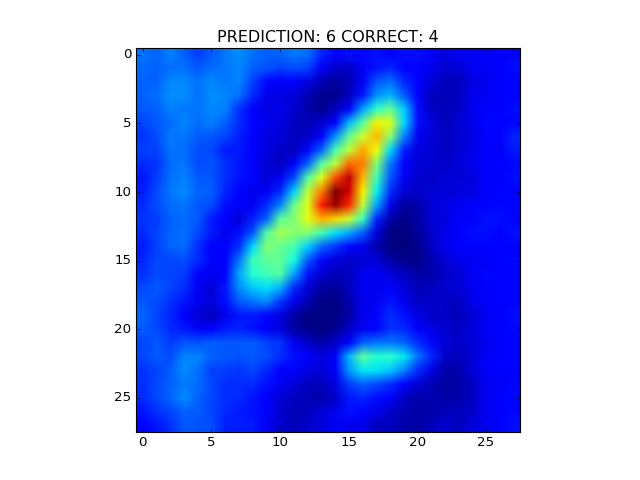

<IPython.core.display.Javascript object>


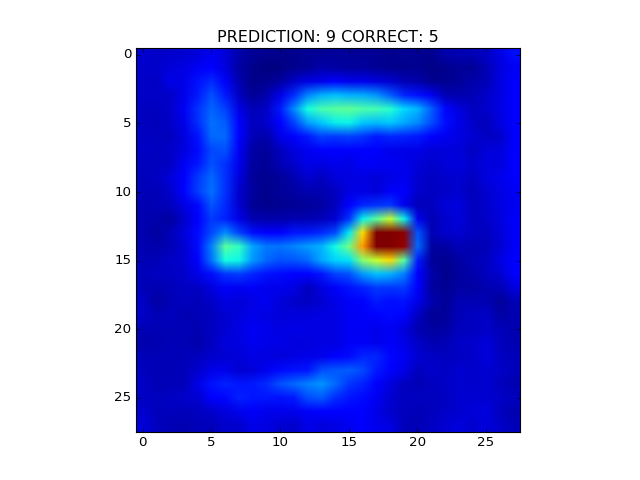

In [12]:
classification, imgs, y_test, misclassified_list = digit_classifier(misclassified=True)

In [14]:
def get_test_images(x_test):
    """Return flattened images. """
    n_samples = len(x_test)
    return x_test.reshape((n_samples, -1))
x_test = pickle.load(open('x_test.p'))
y_test = pickle.load(open('y_test.p'))                

<IPython.core.display.Javascript object>


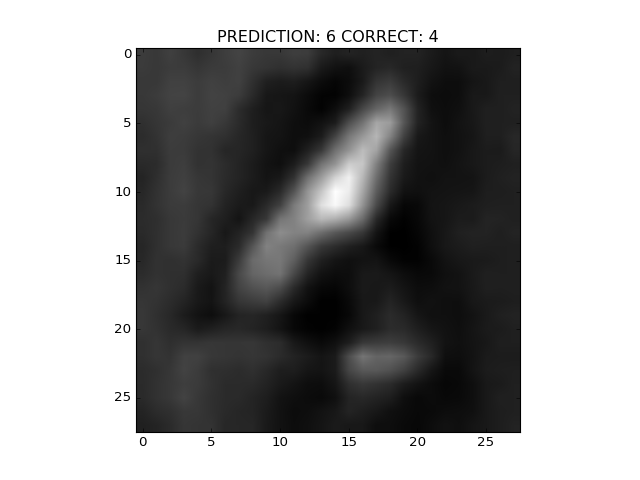

<IPython.core.display.Javascript object>


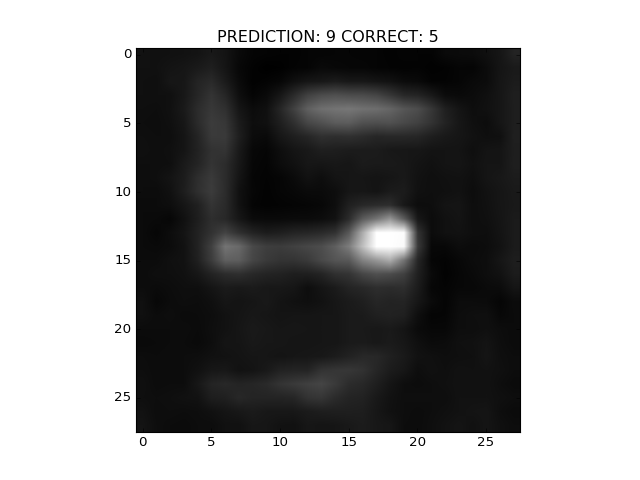

<IPython.core.display.Javascript object>


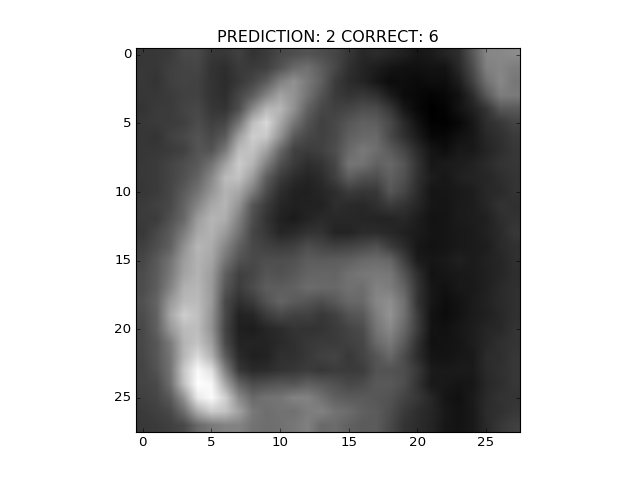

<IPython.core.display.Javascript object>


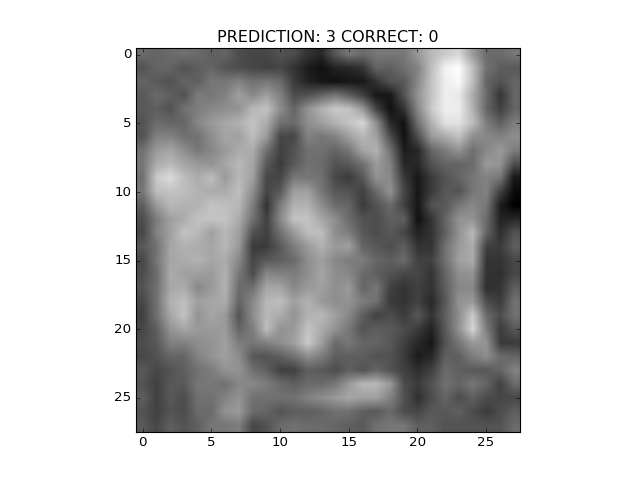

<IPython.core.display.Javascript object>


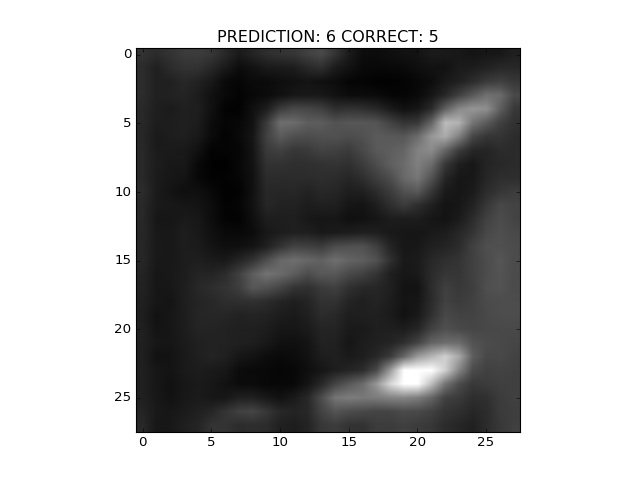

<IPython.core.display.Javascript object>


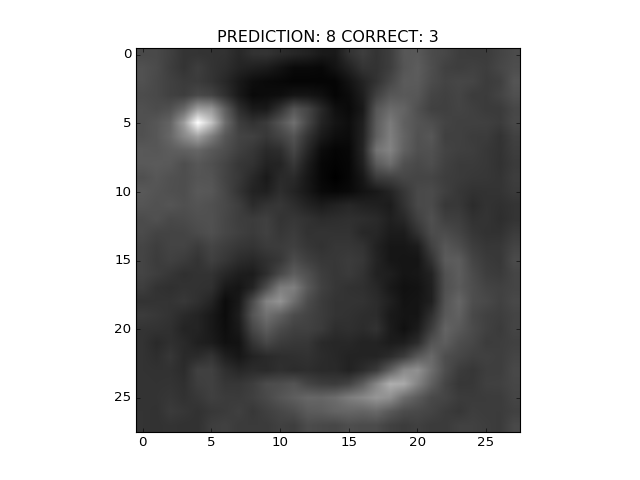

<IPython.core.display.Javascript object>


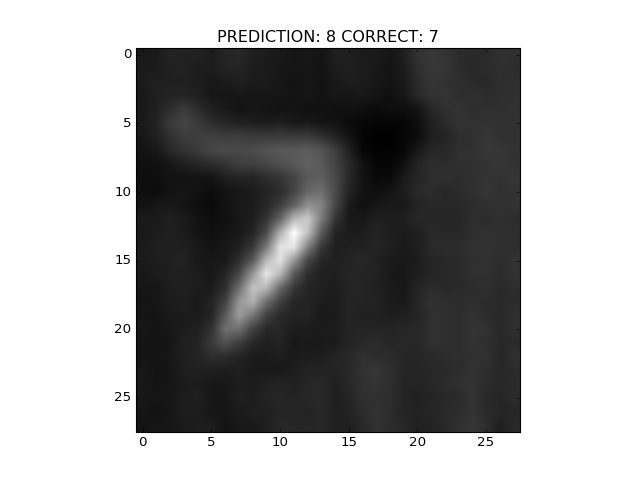

<IPython.core.display.Javascript object>


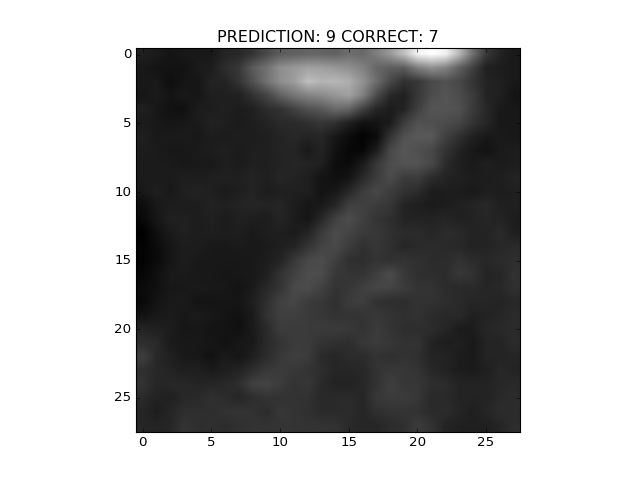

<IPython.core.display.Javascript object>


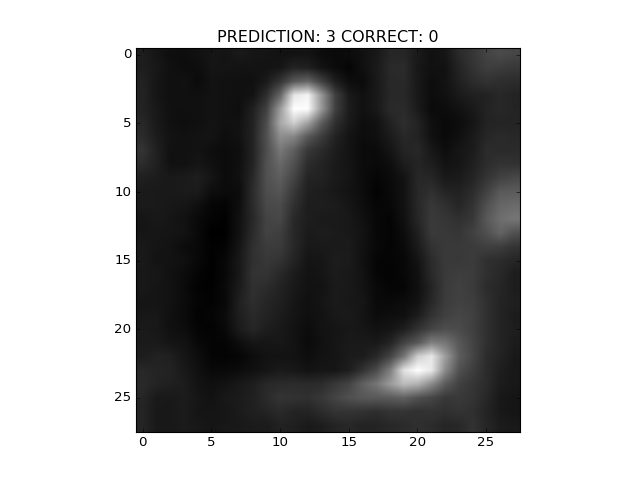

<IPython.core.display.Javascript object>


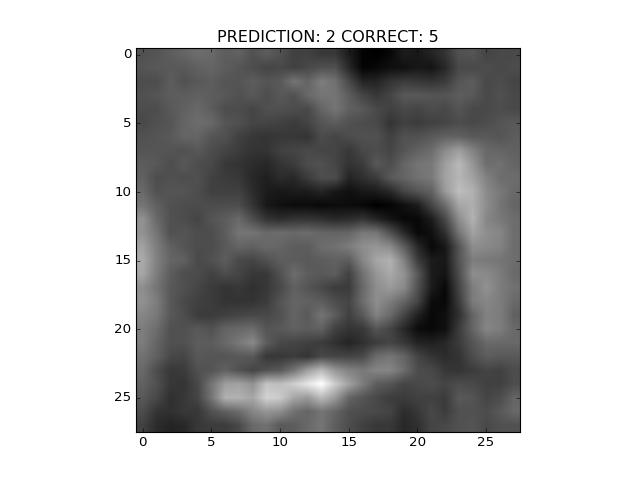

In [15]:
for i in misclassified_list[:10]: 
    plt.figure()
    prediction = np.argmax(classification[i])
    correct = np.argmax(y_test[i])
    plt.title("PREDICTION: " + str(prediction) + ' CORRECT: '+ str(correct))
    plt.imshow(x_test[i].reshape(28,28),cmap='gray')
    plt.show()

In [26]:
# classification, imgs, y_test, misclassified_list
def plot_nth_images(n):
    """Plot nth image in test set"""
    print(n)
    plt.figure()    
    plt.title("actual: " + str(np.argmax(y_test[n])) + "prediction:" + str(np.argmax(classification[n])))
    plt.imshow(imgs[n].reshape(28,28),cmap='gray')
    plt.show()